<div class="alert alert-info">

<H1> Data Analysis Interview Challenge </H1>

<H2> Part 3 ‑ Predictive modeling </H2>

<p>
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
</p>

<p>
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
</p>

The data is in the attached file ultimate_data_challenge.json.
    <ol>
        <li> Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?</li>
        <li> Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.</li>
        <li> Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).</li>
                
   </ol>
    
<H3> Assumptions Made </H3>

The date of when the data was pulled is not given, so I cannot tell if they had a trip in the 30 days before that date, nor is a user ID given.

Thus, the assumptions are:
    <ol>
        <li>That the most recent trip taken was the day the data was pulled</li>
        <li>Each row represents a summary of a unique user </li>
    </ol>

</div>

In [19]:
import pandas as pd
import numpy as np
import json
import pickle

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import seaborn as sns

from datetime import datetime

from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

<div class="alert alert-success">
<H3> Cleaning and EDA </H3>
</div>

In [6]:
# load data
with open('data/ultimate_data_challenge.json') as f:
    data = json.load(f)

# put data info pandas dataframe
user_data = pd.DataFrame(data)

# convert dates to datetime objects
user_data['signup_date'] = pd.to_datetime(user_data['signup_date'])
user_data['last_trip_date'] = pd.to_datetime(user_data['last_trip_date'])

# find the date the data was pulled
pull_date = user_data.last_trip_date.max()

# determine 30 days previous to the pull day
cut_off_day = pull_date - pd.Timedelta('30 days')

# add active status to dataframe 0= inactive, 1 = active
user_data['active_status'] = (user_data.last_trip_date > cut_off_day).astype('int')

# add dummies to categorical data
user_data = pd.get_dummies(user_data, columns = ['city', 'phone'])

In [7]:
# separate the active and inactive users
active_user = user_data[user_data.active_status == 1]
inactive_user = user_data[user_data.active_status == 0]

In [8]:
# fraction of the observed users that were retained
fraction = round((len(active_user.active_status)/len(user_data.active_status)) * 100, 2)
print('{} percent of users were retained.'.format(fraction))

36.62 percent of users were retained.


In [9]:
# calculate the mean and standard deviation for each feature
feature_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'city_Astapor',
 "city_King's Landing", 'city_Winterfell', 'phone_Android','phone_iPhone']
stats_dict = {}
for col in feature_columns:
    stats_dict[col] = [active_user[col].mean(), active_user[col].std(),
                       inactive_user[col].mean(),inactive_user[col].std()]

In [10]:
# create a dataframe of the statistics
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').rename(columns = {0:'active_mean', 1:'active_std', 2:'inactive_mean', 3:'inactive_std'})

Text(0.5, 1.0, 'Average of Features for Active and Inactive Users')

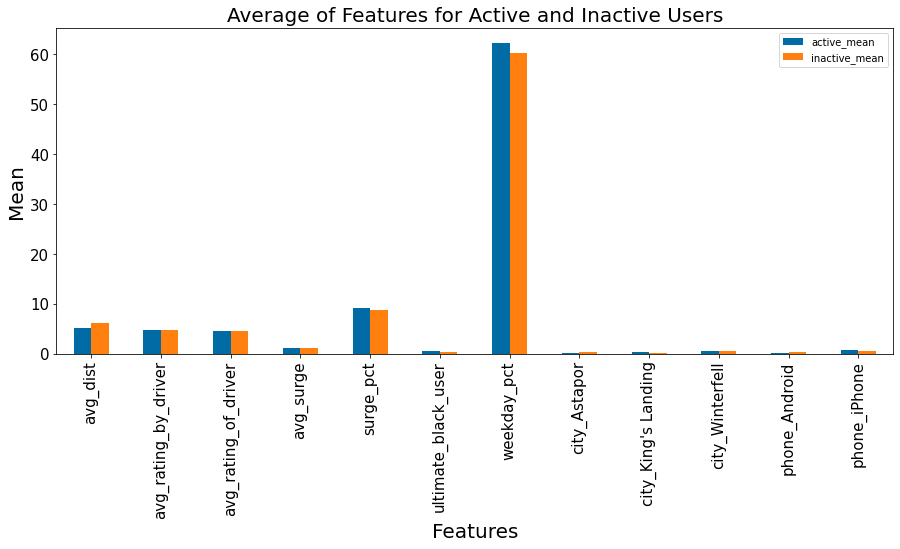

In [11]:
# visualize the statistics
stats_df[['active_mean', 'inactive_mean']].plot(kind = 'bar', yerr=stats_df[['active_std','inactive_std']], figsize = (15,6), fontsize = 15)
plt.xlabel('Features',fontsize = 20)
plt.ylabel('Mean', fontsize = 20)
plt.title('Average of Features for Active and Inactive Users', fontsize = 20)

<div class="alert alert-warning">
<strong>The bar graph of the statistcs shows there is not a pronounce difference between the average of the features for active and inactive users.  It also shows the weekday_pct feature has a much larger scale than the others, so the data may need to be normalized</strong>
</div>

Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

<div class="alert alert-info">
<H3>
<p>
This is a binary classification problem with both numerical and categorical data with 50,000 data points. XGBoost is appropriate for the data, fast, and memory efficient. Other models that would be appropriate for this data would be random forests and logistic regression. One of the drawbacks of using a tree-based model is iThis is a binary classification problem with both numerical and categorical data with 50,000 data points. XGBoost is appropriate for the data, fast, and memory efficient. Other models that would be appropriate for this data would be random forests and logistic regression. One of the drawbacks of using a tree-based model is interpretation is not as straightforward as it is with linear models. 
</p>
</H3>
</div>

<div class="alert alert-success">
<H2> Optimization of XGBoost Classifer Model </H2>

<H3>
<p>
    
<li>split data into training and test sets</li>
<li>optimize hyperparameters using the training set and random crossfold validation</li>
<li>validate using an unoptimized model AND the test set</li>
<li>train optimized model using the entire feature set</li>
</p>
</H3>
</div>

In [12]:
# define features and target
X = user_data[feature_columns]
y = user_data.active_status
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

<div class="alert alert-success">
<H3>Hyperparameter optimization</H3>
</div>

In [13]:
# dictionary of parameters to optimize, and the range of optimization values
parameters = {
    'max_delta_step':[0,0.05],
    'scale_pos_weight':[0.95, 0.9],
    'subsample':[1,0.8],
    'learning_rate': [0.25, 0.2, 0.1],
    'min_child_weight':[0,1,2],
    'gamma':[1, 2, 3]
    }

In [17]:
from platform import python_version

print(python_version())

3.8.3


In [ ]:
# instantiate classifier
xg_clf = XGBClassifier(objective = 'binary:logistic', random_state = 42, silent = 1, n_estimators=10, max_depth= 8)

# RandomSearch
grid_search = GridSearchCV(param_grid= parameters, estimator = xg_clf, cv=3, scoring='accuracy')
grid_search.fit(X_train,y_train)

In [19]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)

{'gamma': 3, 'learning_rate': 0.2, 'max_delta_step': 0, 'min_child_weight': 1, 'scale_pos_weight': 0.95, 'subsample': 1}
0.7829428571428572


<div class="alert alert-success">
<H3>Validate optimized parameters</H3>
</div>

In [28]:
# optimized parameters
optimized_parameters = {'objective':'binary:logistic',
                        'n_estimators': 10,
                        'random_state': 42,
                        'silent': 0,
                        'subsample': 1, 
                        'scale_pos_weight': 0.95, 
                        'min_child_weight': 1, 
                        'max_depth': 8, 
                        'max_delta_step': 0, 
                        'learning_rate': 0.2, 
                        'gamma': 3
                       }

In [29]:
# instantiate classifier
xg_clf_opt = XGBClassifier(**optimized_parameters)
xg_clf_opt.fit(X_train, y_train)

[23:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 86 pruned nodes, max_depth=8
[23:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 104 pruned nodes, max_depth=8
[23:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 150 pruned nodes, max_depth=8
[23:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 164 pruned nodes, max_depth=8
[23:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 160 pruned nodes, max_depth=8
[23:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 154 pruned nodes, max_depth=8
[23:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 144 pruned nodes, max_depth=8
[23:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 132 pruned nodes, max_depth=8
[23:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nod

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=3, learning_rate=0.2, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.95,
       seed=None, silent=0, subsample=1)

In [30]:
# predict the labels
y_opt_pred = xg_clf_opt.predict(X_train)
# score model
score = accuracy_score(y_train, y_opt_pred)
# print accuracy
print("The resulting accuracy of the optimized classifier is {}.".format(round(score,4)))

The resulting accuracy of the optimized classifier is 0.8033.


/home/aregel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [31]:
# train unoptimized model
xg_clf.fit(X_train, y_train)
# predict the labels of unoptimized model
y_unopt_pred = xg_clf.predict(X_train)
# score model
un_score = accuracy_score(y_train, y_unopt_pred)
# print accuracy
print("The resulting accuracy of the unoptimized classifier is {}.".format(round(un_score,4)))

The resulting accuracy of the unoptimized classifier is 0.7969.


/home/aregel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


<div class="alert alert-warning">
<strong>The optimization process did improve the model using the training data, so the next step is to see how it performs with the test set.</strong>
</div>

In [32]:
# predict the labels
y_opt_test = xg_clf_opt.predict(X_test)
# score model
test_score = accuracy_score(y_test, y_opt_test)
# print accuracy
print("The resulting accuracy of the optimized classifier for the test set is {}.".format(round(test_score,4)))

The resulting accuracy of the optimized classifier for the test set is 0.7873.


/home/aregel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [33]:
# predict the labels of unoptimized model using the test set
y_unopt_test = xg_clf.predict(X_train)
# score model
test_score = accuracy_score(y_train, y_unopt_test)
# print accuracy
print("The resulting accuracy of the unoptimized classifier is {}.".format(round(test_score,4)))

The resulting accuracy of the unoptimized classifier is 0.7969.


/home/aregel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


<div class="alert alert-warning">
<strong>The optimized model performs worse with the test set, which means it is overfitting. Therefore, I will train the final model with all of the data using the default values</strong>
</div>

In [34]:
# instantiate classifier
xg_clf_final = XGBClassifier(objective = 'binary:logistic', random_state = 42, silent = 1, n_estimators=200, max_depth= 8)
# train final model
xg_clf_final.fit(X, y)
# save model
pickle.dump(xg_clf_final, open('final_model.pickle', 'wb'))


<div class="alert alert-success">
<H2> Model Insights </H2>

<H3>
<p>
    
<li>Determine the most important features of the model</li>
<li>Discuss what that means for rider retention</li>

</p>
</H3>
</div>

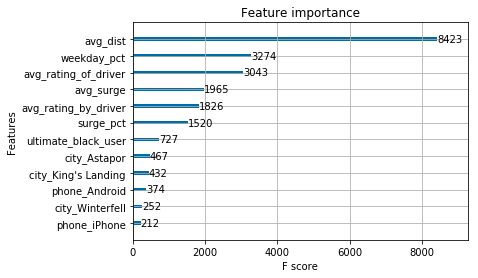

In [35]:
plot_importance(xg_clf_final)

<div class="alert alert-warning">
<H2> Conclusion: </H2>
<H4>
<strong>The default parameters produced the best performing XGBoost model, resulting in a classification accuracy of 85.43% for the test data.  The factors that most heavily influence rider retention are the average distance in miles per trip taken in the first 30 days after signup and the percent of the user's trips occuring during a weekday. </strong>
</H4>
</div>